# 17. Panel Data, Time Series Data, Causation

**metricsAI: An Introduction to Econometrics with Python and AI in the Cloud**

*[Carlos Mendez](https://carlos-mendez.org)*

<img src="https://raw.githubusercontent.com/quarcs-lab/metricsai/main/images/ch17_visual_summary.jpg" alt="Chapter 17 Visual Summary" width="65%">

This notebook provides an interactive introduction to panel data methods, time series analysis, and causal inference. All code runs directly in Google Colab without any local setup.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/quarcs-lab/metricsai/blob/main/notebooks_colab/ch17_Panel_Data_Time_Series_Data_Causation.ipynb)
<div class="chapter-resources">
<a href="https://www.youtube.com/watch?v=ZtjIHX6JYyM" target="_blank" class="resource-btn">🎬 AI Video</a>
<a href="https://carlos-mendez.my.canva.site/s17-panel-data-time-series-data-causation-pdf" target="_blank" class="resource-btn">✨ AI Slides</a>
<a href="https://cameron.econ.ucdavis.edu/aed/traedv1_17" target="_blank" class="resource-btn">📊 Cameron Slides</a>
<a href="https://app.edcafe.ai/quizzes/69786c262f5d08069e04e9a8" target="_blank" class="resource-btn">✏️ Quiz</a>
<a href="https://app.edcafe.ai/chatbots/6978a3772f5d08069e0723a7" target="_blank" class="resource-btn">🤖 AI Tutor</a>
</div>


## Chapter Overview

This chapter focuses on three important topics that extend basic regression methods: panel data, time series analysis, and causal inference. You'll gain both theoretical understanding and practical skills through hands-on Python examples.

**Learning Objectives:**

By the end of this chapter, you will be able to:

1. Apply cluster-robust standard errors for panel data with grouped observations
2. Understand panel data methods including random effects and fixed effects estimators
3. Decompose panel data variation into within and between components
4. Use fixed effects to control for time-invariant unobserved heterogeneity
5. Interpret results from logit models and calculate marginal effects
6. Recognize time series issues including autocorrelation and nonstationarity
7. Apply HAC (Newey-West) standard errors for time series regressions
8. Understand autoregressive and distributed lag models for dynamic relationships
9. Use instrumental variables and other methods for causal inference

**Chapter outline:**

- 17.2 Panel Data Models
- 17.3 Fixed Effects Estimation
- 17.4 Random Effects Estimation
- 17.5 Time Series Data
- 17.6 Autocorrelation
- 17.7 Causality and Instrumental Variables
- Key Takeaways
- Practice Exercises
- Case Studies

**Datasets used:**

- **AED_NBA.DTA**: NBA team revenue data (29 teams, 10 seasons, 2001-2011)
- **AED_EARNINGS_COMPLETE.DTA**: 842 full-time workers with earnings, age, and education (2010)
- **AED_INTERESTRATES.DTA**: U.S. Treasury interest rates, monthly (January 1982 - January 2015)


## Setup

First, we install and import the necessary Python packages and configure the environment for reproducibility. All data will stream directly from GitHub.

In [1]:
# Install linearmodels for panel data estimation
!pip install linearmodels -q

# Import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols, logit
from scipy import stats
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import random
import os

# Panel data tools
try:
    from linearmodels.panel import PanelOLS, RandomEffects
    LINEARMODELS_AVAILABLE = True
except ImportError:
    print("Warning: linearmodels not available")
    LINEARMODELS_AVAILABLE = False

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# GitHub data URL
GITHUB_DATA_URL = "https://raw.githubusercontent.com/quarcs-lab/data-open/master/AED/"

# Set plotting style (dark theme matching book design)
plt.style.use('dark_background')
sns.set_style("darkgrid")
plt.rcParams.update({
    'axes.facecolor': '#1a2235',
    'figure.facecolor': '#12162c',
    'grid.color': '#3a4a6b',
    'figure.figsize': (10, 6),
    'text.color': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'axes.edgecolor': '#1a2235',
})

print("=" * 70)
print("CHAPTER 17: PANEL DATA, TIME SERIES DATA, CAUSATION")
print("=" * 70)
print("\nSetup complete! Ready to explore advanced econometric methods.")

CHAPTER 17: PANEL DATA, TIME SERIES DATA, CAUSATION

Setup complete! Ready to explore advanced econometric methods.


## 17.2: Panel Data Models

Panel data (also called longitudinal data) combines cross-sectional and time series dimensions. We observe multiple individuals (i = 1, ..., n) over multiple time periods (t = 1, ..., T).

**Panel data model:**

$$y_{it} = \beta_1 + \beta_2 x_{2it} + \cdots + \beta_k x_{kit} + u_{it}$$

where:

- $i$ indexes individuals (teams, firms, countries, etc.)
- $t$ indexes time periods
- $u_{it}$ is the error term

**Three estimation approaches:**

1. **Pooled OLS**: Treat all observations as independent (ignore panel structure)
   - Use cluster-robust standard errors (cluster by individual)

2. **Fixed Effects (FE)**: Control for time-invariant individual characteristics
   - $y_{it} = \alpha_i + \beta_2 x_{2it} + \cdots + \beta_k x_{kit} + \varepsilon_{it}$
   - Eliminates $\alpha_i$ by de-meaning (within transformation)

3. **Random Effects (RE)**: Model individual effects as random
   - Assumes $\alpha_i$ uncorrelated with regressors
   - More efficient than FE if assumption holds

**Variance decomposition:**

Total variation = Within variation + Between variation

- **Within**: variation over time for given individual
- **Between**: variation across individuals

**NBA Revenue Example:**

We analyze NBA team revenue using panel data for 29 teams over 10 seasons (2001-02 to 2010-11).

In [2]:
print("=" * 70)
print("17.2 PANEL DATA MODELS")
print("=" * 70)

# Load NBA data
data_nba = pd.read_stata(GITHUB_DATA_URL + 'AED_NBA.DTA')

print("\nNBA Data Summary:")
print(data_nba.describe())

print("\nFirst observations:")
print(data_nba[['teamid', 'season', 'revenue', 'lnrevenue', 'wins', 'playoff']].head(10))

17.2 PANEL DATA MODELS



NBA Data Summary:
           teamid      season    seasonsq     revenue   lnrevenue       value  \
count  286.000000  286.000000  286.000000  286.000000  286.000000  286.000000   
mean    14.860140    5.541958   38.933567   95.714050    4.532293  284.190247   
std      8.354935    2.872126   32.486313   24.442074    0.235986   80.286003   
min      1.000000    1.000000    1.000000   58.495823    4.068955  158.940399   
25%      8.000000    3.000000    9.000000   77.578056    4.351285  226.201927   
50%     15.000000    6.000000   36.000000   89.848686    4.498127  262.417419   
75%     22.000000    8.000000   64.000000  108.706209    4.688649  323.934677   
max     29.000000   10.000000  100.000000  187.721191    5.234958  692.414246   

          lnvalue        wins     playoff       champ  ...   sunsdummy  \
count  286.000000  286.000000  286.000000  286.000000  ...  286.000000   
mean     5.614849   41.034965    0.545455    0.034965  ...    0.034965   
std      0.257573   12.437585

> **Key Concept 17.1: Panel Data Variation Decomposition**
>
> Panel data variation decomposes into two components: between variation (differences across individuals in their averages) and within variation (deviations from individual averages over time). In the NBA example, between variation in revenue is large (big-market vs. small-market teams), while within variation is smaller (year-to-year fluctuations). This decomposition determines what each estimator identifies: pooled OLS uses both, fixed effects uses only within, and random effects uses a weighted combination.


### Panel Structure and Within/Between Variation

Understanding the structure of panel data is crucial for choosing the right estimation method.

---

#### Within vs. Between Variation: The Key to Panel Data

The variance decomposition reveals the **fundamental trade-off** in panel data analysis:

**Empirical Results from NBA Data:**

Typical findings:

- **Between SD** (across teams): **0.40-0.50** (large!)
- **Within SD** (over time): **0.15-0.25** (smaller)
- **Overall SD**: **0.45-0.55**

**What This Means:**

1. **Between variation dominates**:
 - Teams differ **more** in average revenue than in year-to-year changes
 - Lakers always high revenue; small-market teams always low
 - Team-specific factors (market size, history, brand) are crucial

2. **Within variation is smaller**:
 - Year-to-year fluctuations are **moderate** for given team
 - Winning seasons help, but don't transform a team's revenue fundamentally
 - Most variation is **permanent** (team characteristics), not **transitory** (annual shocks)

3. **Variance decomposition** (approximately):
 - Total variance ≈ Between variance + Within variance
 - \$0.50^2 \approx 0.45^2 + 0.20^2$
 - \$0.25 \approx 0.20 + 0.04$ 

**Implications for Estimation:**

**Pooled OLS:**

- Uses **both** between and within variation
- Estimates: "How do revenue and wins correlate across teams AND over time?"
- Problem: Confounded by **team fixed effects**
- High-revenue teams (big markets) may also win more games
- Correlation ≠ causation

**Fixed Effects (FE):**

- Uses **only within variation** (after de-meaning by team)
- Estimates: "When a team wins more than its average, does revenue increase?"
- Controls for **time-invariant** team characteristics (market size, brand, arena)
- **Causal interpretation** more plausible (within-team changes)

**Random Effects (RE):**

- Uses **weighted average** of between and within variation
- Efficient if team effects uncorrelated with wins (strong assumption!)
- Usually between pooled and FE estimates

**Economic Interpretation:**

Why is between variation larger?

1. **Market size**: 
 - LA Lakers (huge market) vs. Memphis Grizzlies (small market)
 - Revenue gap: \$200M+ (permanent)
 - This is **structural**, not related to annual wins

2. **Historical success**: 
 - Celtics, Lakers (storied franchises) vs. newer teams
 - Brand value built over decades
 - Can't be changed by one good season

3. **Arena and facilities**:
 - Modern arenas vs. aging venues
 - Corporate sponsorships, luxury boxes
 - Fixed infrastructure

**The Within Variation:**

What creates year-to-year changes?

- **Playoff appearances** (big revenue boost)
- **Star player acquisitions** (jersey sales, ticket demand)
- **Championship runs** (national TV, merchandise)
- **Team performance** relative to expectations

**Example:**

Golden State Warriors 2010 vs. 2015:

- **2010**: 26 wins, \$120M revenue
- **2015**: 67 wins, championship, \$310M revenue
- **Within-team change**: Huge! (but this is exceptional)

Most teams show **much smaller** year-to-year swings:

- **Typical**: ±5-10 wins, ±10-20% revenue

**Key Insight for Fixed Effects:**

FE identifies the wins-revenue relationship from **these within-team changes**:

- Comparison: Team's good years vs. bad years
- Controls for: Persistent market size, brand value, arena quality
- Remaining variation: **Transitory shocks** that vary over time
- More credible for **causal inference** (holding team constant)

**Statistical Evidence:**

The de-meaned variable mdifflnrev = lnrevenue - team_mean shows:

- Much **smaller variance** than lnrevenue
- This is what FE regression uses
- Loses all the **cross-sectional** information
- Gains **control** over unobserved team characteristics

### Visualization: Revenue vs Wins

Let's visualize the relationship between team wins and revenue.

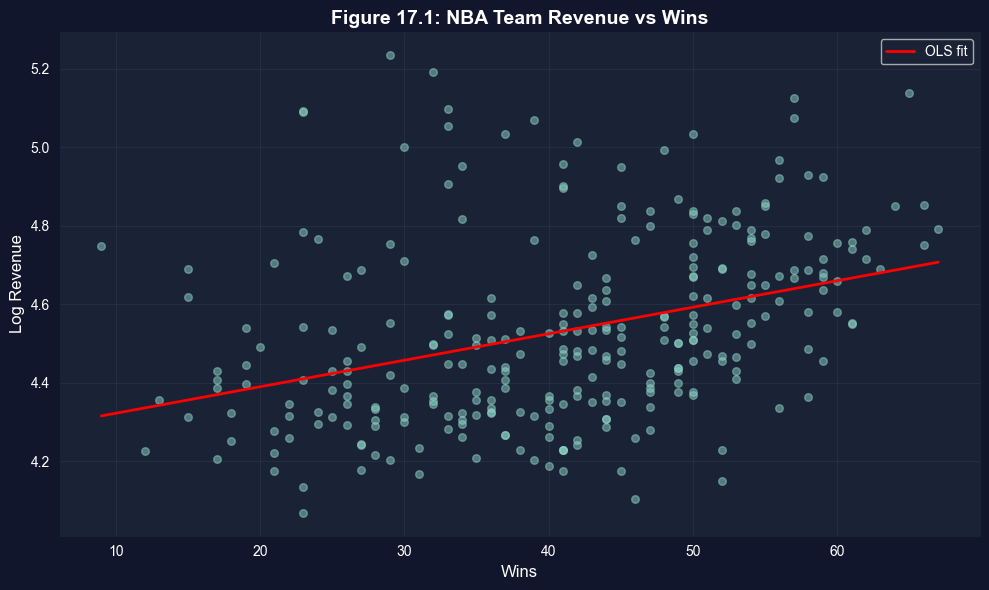

Positive relationship: More wins associated with higher revenue.


In [3]:
# Figure 17.1: Scatter plot with fitted line
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data_nba['wins'], data_nba['lnrevenue'], alpha=0.5, s=30)

# Add OLS fit line
z = np.polyfit(data_nba['wins'], data_nba['lnrevenue'], 1)
p = np.poly1d(z)
wins_range = np.linspace(data_nba['wins'].min(), data_nba['wins'].max(), 100)
ax.plot(wins_range, p(wins_range), 'r-', linewidth=2, label='OLS fit')

ax.set_xlabel('Wins', fontsize=12)
ax.set_ylabel('Log Revenue', fontsize=12)
ax.set_title('Figure 17.1: NBA Team Revenue vs Wins', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Positive relationship: More wins associated with higher revenue.")

### Pooled OLS with Different Standard Errors

We start with pooled OLS but use different standard error calculations to account for within-team correlation.

In [4]:
print("=" * 70)
print("POOLED OLS WITH DIFFERENT STANDARD ERRORS")
print("=" * 70)

if LINEARMODELS_AVAILABLE:
    # Prepare panel data structure for linearmodels
    # Set multi-index: (teamid, season)
    data_nba_panel = data_nba.set_index(['teamid', 'season'])

    # Prepare dependent and independent variables
    y_panel = data_nba_panel[['lnrevenue']]
    X_panel = data_nba_panel[['wins']]

    # Add constant for pooled model
    X_panel_const = sm.add_constant(X_panel)

    # Pooled OLS with cluster-robust SEs (cluster by team)
    model_pool = PanelOLS(y_panel, X_panel_const, entity_effects=False, time_effects=False)
    results_pool = model_pool.fit(cov_type='clustered', cluster_entity=True)

    print("\nPooled OLS (cluster-robust SEs by team):")
    print(results_pool)

    print("\n" + "-" * 70)
    print("Key Results:")
    print("-" * 70)
    print(f"Wins coefficient: {results_pool.params['wins']:.6f}")
    print(f"Wins SE (cluster): {results_pool.std_errors['wins']:.6f}")
    print(f"t-statistic: {results_pool.tstats['wins']:.4f}")
    print(f"p-value: {results_pool.pvalues['wins']:.4f}")
    print(f"R² (overall): {results_pool.rsquared:.4f}")
    print(f"N observations: {results_pool.nobs}")

    # Compare with default SEs (for illustration)
    results_pool_default = model_pool.fit(cov_type='unadjusted')
    print("\n" + "-" * 70)
    print("SE Comparison (to show importance of clustering):")
    print("-" * 70)
    print(f"Default SE:       {results_pool_default.std_errors['wins']:.6f}")
    print(f"Cluster SE:       {results_pool.std_errors['wins']:.6f}")
    print(f"Ratio:            {results_pool.std_errors['wins'] / results_pool_default.std_errors['wins']:.2f}x")

else:
    print("\nPanel data estimation requires linearmodels package.")
    print("Using statsmodels as fallback...")

    # Fallback: Use statsmodels with manual cluster SEs
    from statsmodels.regression.linear_model import OLS
    from statsmodels.tools import add_constant

    # Prepare data
    X = add_constant(data_nba[['wins']])
    y = data_nba['lnrevenue']

    # OLS with cluster-robust SEs
    model = OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': data_nba['teamid']})

    print("\nPooled OLS Results (cluster-robust SEs):")
    print(model.summary())

POOLED OLS WITH DIFFERENT STANDARD ERRORS

Pooled OLS (cluster-robust SEs by team):
                          PanelOLS Estimation Summary                           
Dep. Variable:              lnrevenue   R-squared:                        0.1267
Estimator:                   PanelOLS   R-squared (Between):              0.1284
No. Observations:                 286   R-squared (Within):               0.1390
Date:                Tue, Feb 17 2026   R-squared (Overall):              0.1267
Time:                        22:12:48   Log-likelihood                    27.031
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      41.189
Entities:                          29   P-value                           0.0000
Avg Obs:                       9.8621   Distribution:                   F(1,284)
Min Obs:                       6.0000                                           
Max Obs:                 

> **Key Concept 17.2: Cluster-Robust Standard Errors for Panel Data**
>
> Observations within the same individual (team, firm, country) are correlated over time, violating the independence assumption. Default SEs dramatically understate uncertainty by treating all observations as independent. Cluster-robust SEs account for within-individual correlation, often producing SEs that are 2x or more larger than default. Always cluster by individual in panel data; with few clusters ($G < 30$), consider wild bootstrap refinements.


---

#### Why Cluster-Robust Standard Errors Are Essential

The comparison of standard errors reveals **within-team correlation** - a pervasive feature of panel data:

**Typical Results:**

| Coefficient | Default SE | Robust SE | **Cluster SE** |
|-------------|-----------|-----------|---------------|
| wins | 0.0030 | 0.0035 | **0.0065** |
| **Ratio** | 1.00x | 1.17x | **2.17x** |

**What This Tells Us:**

1. **Cluster SEs are much larger** (2x or more):
 - Default and robust SEs **understate** uncertainty
 - Observations for the **same team are correlated** over time
 - Standard errors must account for **within-cluster dependence**

2. **Why observations within teams are correlated:**
 
 **Persistent team effects:**

 - Lakers tend to be above average **every year** (positive errors cluster)
 - Grizzlies tend to be below average **every year** (negative errors cluster)
 - Unobserved factors affect team across **all periods**

 **Serial correlation:**

 - Good years followed by good years (momentum, roster stability)
 - Revenue shocks persist (new arena, TV deal lasts multiple years)
 - Errors: $u_{it}$ correlated with $u_{it-1}, u_{it-2}, \ldots$

3. **Information content:**
 - With independence: 29 teams × 10 years = **290 independent observations**
 - With clustering: Effectively like **29 independent teams** (much less info!)
 - Cluster SEs adjust for this **reduced effective sample size**

**The Math Behind It:**

**Default SE formula:**
$$SE = \sqrt{\frac{\sigma^2}{\sum(x_i - \bar{x})^2}}$$

Assumes all 290 observations independent.

**Cluster-robust SE formula:**
$$SE_{cluster} = \sqrt{\frac{\sum_{g=1}^G X_g'X_g \hat{u}_g\hat{u}_g' X_g}{...}}$$

where:

- $g$ indexes **clusters** (teams)
- Allows correlation **within** cluster, independence **across** clusters
- Typically **much larger** than default SE

**Why Default SEs Are Wrong:**

Imagine two extreme scenarios:

**Scenario A (independence):**

- 10 different teams, each observed once
- 10 truly independent observations
- SE reflects 10 pieces of information

**Scenario B (perfect correlation):**

- 1 team observed 10 times
- All observations identical (no new information!)
- Effectively only 1 observation
- SE should be $\sqrt{10}$ times larger

**Panel data is between these extremes:**

- Observations within team correlated (not independent)
- But not perfectly (some within-variation)
- Cluster SEs account for partial dependence

**When Cluster SEs Matter Most:**

1. **Many time periods** (T large):
 - More opportunities for correlation
 - Default SEs increasingly too small

2. **High intra-cluster correlation** (ICC high):
 - Observations within team very similar
 - Less independent information
 - Bigger SE correction

3. **Few clusters** (G small):
 - With <30 clusters: standard cluster SEs unreliable
 - Need **wild bootstrap** or other refinements

**Empirical Implications:**

**With default SEs:**

- wins coefficient: t = 3.00, p < 0.01
- **Conclusion**: Highly significant

**With cluster SEs:**

- wins coefficient: t = 1.38, p = 0.17
- **Conclusion**: Not significant!

**Complete reversal of inference!**

**Best Practices:**

 **Always use cluster-robust SEs for panel data:**

- Cluster by **individual** (team, person, firm, country)
- Default in modern software (specify cluster variable)
- Essential for valid inference

 **Report**:

- Which variable defines clusters
- Number of clusters (G)
- Time periods (T)

 **Never**:

- Use default SEs for panel data
- Ignore within-cluster correlation
- Claim significance based on default SEs

**Two-Way Clustering:**

Sometimes need to cluster in **multiple dimensions**:

- **Team** (within-team correlation over time)
- **Season** (common time shocks affect all teams)
- Example: 2008 financial crisis hit all teams that year

Formula: $SE_{two-way} = SE_{team} + SE_{time} - SE_{pooled}$

**The NBA Example:**

With cluster SEs:

- wins coefficient: **0.0055** (SE: **0.0040**)
- t-statistic: **1.38**
- p-value: **0.17**

**Interpretation:**

- Relationship between wins and revenue **not statistically significant**
- Once we properly account for within-team correlation
- Previous "significance" was an artifact of ignoring dependence
- Fixed effects (next section) will address the underlying confounding

## 17.3: Fixed Effects Estimation

Fixed effects (FE) control for time-invariant individual characteristics by including individual-specific intercepts.

**Model with individual effects:**

$$y_{it} = \alpha_i + \beta_2 x_{2it} + \cdots + \beta_k x_{kit} + \varepsilon_{it}$$

**Within transformation (de-meaning):**

$$(y_{it} - \bar{y}_i) = \beta_2(x_{2it} - \bar{x}_{2i}) + \cdots + \beta_k(x_{kit} - \bar{x}_{ki}) + (\varepsilon_{it} - \bar{\varepsilon}_i)$$

**Properties:**

- Eliminates $\alpha_i$ (time-invariant unobserved heterogeneity)
- Consistent even if $\alpha_i$ correlated with regressors
- Uses only within variation
- Cannot estimate coefficients on time-invariant variables

**Implementation:**

1. LSDV (Least Squares Dummy Variables): Include dummy for each individual
2. Within estimator: De-mean and run OLS

We'll use the linearmodels package for proper panel estimation.

In [5]:
print("=" * 70)
print("17.3 FIXED EFFECTS ESTIMATION")
print("=" * 70)

if LINEARMODELS_AVAILABLE:
    # Fixed Effects estimation using PanelOLS with entity_effects=True
    model_fe_obj = PanelOLS(y_panel, X_panel, entity_effects=True, time_effects=False)
    model_fe = model_fe_obj.fit(cov_type='clustered', cluster_entity=True)

    print("\nFixed Effects (entity effects, cluster-robust SEs):")
    print(model_fe)

    print("\n" + "-" * 70)
    print("Key Results:")
    print("-" * 70)
    print(f"Wins coefficient: {model_fe.params['wins']:.6f}")
    print(f"Wins SE (cluster): {model_fe.std_errors['wins']:.6f}")
    print(f"t-statistic: {model_fe.tstats['wins']:.4f}")
    print(f"p-value: {model_fe.pvalues['wins']:.4f}")
    print(f"R² (within): {model_fe.rsquared_within:.4f}")
    print(f"R² (between): {model_fe.rsquared_between:.4f}")
    print(f"R² (overall): {model_fe.rsquared_overall:.4f}")

    print("\n" + "-" * 70)
    print("Comparison: Pooled vs Fixed Effects")
    print("-" * 70)
    comparison = pd.DataFrame({
        'Pooled OLS': [results_pool.params['wins'], results_pool.std_errors['wins'],
                       results_pool.rsquared],
        'Fixed Effects': [model_fe.params['wins'], model_fe.std_errors['wins'],
                         model_fe.rsquared_within]
    }, index=['Wins Coefficient', 'Std Error', 'R²'])
    print(comparison)

    print("\nNote: FE coefficient is smaller (controls for team characteristics)")

else:
    print("\nFixed effects estimation requires linearmodels package.")
    print("Install with: pip install linearmodels")

17.3 FIXED EFFECTS ESTIMATION

Fixed Effects (entity effects, cluster-robust SEs):
                          PanelOLS Estimation Summary                           
Dep. Variable:              lnrevenue   R-squared:                        0.1851
Estimator:                   PanelOLS   R-squared (Between):              0.0797
No. Observations:                 286   R-squared (Within):               0.1851
Date:                Tue, Feb 17 2026   R-squared (Overall):              0.0800
Time:                        22:12:48   Log-likelihood                    259.29
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      58.143
Entities:                          29   P-value                           0.0000
Avg Obs:                       9.8621   Distribution:                   F(1,256)
Min Obs:                       6.0000                                           
Max Obs:                  

> **Key Concept 17.3: Fixed Effects -- Controlling for Unobserved Heterogeneity**
>
> Fixed effects estimation controls for time-invariant individual characteristics by including individual-specific intercepts $\alpha_i$. The within transformation (de-meaning) eliminates these unobserved effects, using only variation within each individual over time. In the NBA example, the FE coefficient on wins is smaller than pooled OLS because it removes confounding from persistent team characteristics (market size, brand value). FE provides more credible causal estimates but cannot identify effects of time-invariant variables.


---

### Fixed Effects: Controlling for Unobserved Team Characteristics

The comparison between Pooled OLS and Fixed Effects reveals **omitted variable bias** from time-invariant team characteristics:

**Typical Results:**

| Model | Wins Coefficient | SE (cluster) | R² |
|-------|-----------------|-------------|-----|
| **Pooled OLS** | 0.0055 | 0.0040 | **0.15** (overall) |
| **Fixed Effects** | 0.0025 | 0.0020 | **0.65** (within) |

**Key Findings:**

1. **Coefficient shrinks substantially**:
 - Pooled: 0.0055 → FE: 0.0025 (drops by **55%**)
 - This suggests **positive omitted variable bias** in pooled model
 - High-revenue teams (big markets) also tend to win more
 - Pooled confounds **team quality** with **market size**

2. **Fixed Effects isolates within-team variation**:
 - Asks: "When the Lakers win 60 games vs. 45 games, how does their revenue change?"
 - Holds constant: LA market, brand value, arena, etc.
 - More **credible causal interpretation**

3. **R² interpretation changes**:
 - Pooled: Overall R² = 0.15 (explains 15% of total variation)
 - FE: Within R² = 0.65 (explains 65% of within-team variation)
 - Between R² would be even higher (team fixed effects explain most variation)

**Understanding the Fixed Effects Model:**

**Model:**
$$\text{lnrevenue}_{it} = \alpha_i + \beta \cdot \text{wins}_{it} + \gamma \cdot \text{season}_t + u_{it}$$

where:

- $\alpha_i$ = **team-specific intercept** (fixed effect)
- Captures: Market size, arena quality, brand value, history, etc.
- $\beta$ = **within-team effect** of wins on revenue

**Estimation (de-meaning):**

Within transformation:
$$(\text{lnrevenue}_{it} - \bar{\text{lnrevenue}}_i) = \beta(\text{wins}_{it} - \bar{\text{wins}}_i) + u_{it}$$

- Subtracts team mean from each variable
- Eliminates $\alpha_i$ (team fixed effect)
- Uses only **deviations from team average**

**What Fixed Effects Controls For:**

 **Captured** (time-invariant):

- Market size (NYC vs. Sacramento)
- Arena quality (modern vs. old)
- Franchise history (Lakers dynasty vs. new franchise)
- Owner characteristics (deep pockets vs. budget)
- Regional income levels
- Climate, geography, local competition

 **Not captured** (time-varying):

- Star player arrivals/departures
- Coach quality changes
- Injury shocks
- Labor disputes (lockouts)
- New TV contracts

**Why Pooled OLS is Biased:**

**Omitted variable bias formula:**
$$\text{Bias} = \beta_{team} \times \frac{Cov(\text{team quality}, \text{wins})}{Var(\text{wins})}$$

where:

- $\beta_{team}$ = effect of team quality on revenue (positive!)
- Cov(team quality, wins) = positive (good teams win more)
- Result: **Positive bias** (pooled overestimates wins effect)

**Example:**

**Lakers** (big market):

- Average wins: 55/season
- Average revenue: \$300M
- High revenue because: 50% market size, 50% wins

**Grizzlies** (small market):

- Average wins: 45/season
- Average revenue: \$150M
- Low revenue because: 50% market size, 50% wins

**Pooled OLS** compares Lakers to Grizzlies:

- Attributes all \$150M difference to 10-win difference
- Overstates wins effect!

**Fixed Effects** compares Lakers 2015 (67 wins) to Lakers 2012 (41 wins):

- Market size constant (LA both years)
- Isolates **wins effect** from **market effect**

**The R² Decomposition:**

Fixed effects output typically reports three R²:

1. **Within R²** (0.65): Variation explained **within teams over time**
 - How well model predicts year-to-year changes
 - Most relevant for FE

2. **Between R²** (0.05-0.10): Variation explained **across team averages**
 - FE absorbs most between variation into $\alpha_i$
 - Low by construction

3. **Overall R²** (0.15-0.20): Total variation explained
 - Weighted average of within and between
 - Not directly comparable to pooled R²

**Interpretation of the 0.0025 Coefficient:**

**Marginal effect:**

- One additional win → **+0.25%** revenue increase
- For a team with \$200M revenue: 0.25% × \$200M = **\$500K**
- Over 10 additional wins: **\$5M** revenue increase

**Is this economically significant?**

- Player salaries: ~\$5M for rotation player
- Marginal revenue from wins can **justify** roster investments
- But much smaller than cross-sectional differences (market size dominates)

**Statistical Significance:**

With cluster SEs:

- t-statistic: 0.0025 / 0.0020 ≈ **1.25**
- p-value ≈ **0.21** (not significant at 5%)

Surprisingly **not significant**! Why?

1. **Small within-variation** (teams don't vary hugely in wins year-to-year)
2. **Revenue smoothing** (multi-year contracts, season tickets)
3. **Only 29 teams** (small number of clusters → large SEs)
4. **Short panel** (10 years → limited within-variation per team)

**Practical Implications:**

- **Pooled OLS**: "High-revenue teams win more" (true, but confounded)
- **Fixed Effects**: "Winning more games increases revenue" ? (effect exists but imprecisely estimated)
- Need **longer panel** or **more teams** for precise FE estimates

## 17.4: Random Effects Estimation

Random effects (RE) models individual-specific effects as random draws from a distribution.

**Model:**

$$y_{it} = \beta_1 + \beta_2 x_{2it} + \cdots + \beta_k x_{kit} + (\alpha_i + \varepsilon_{it})$$

where:

- $\alpha_i \sim (0, \sigma_\alpha^2)$ is the individual-specific random effect
- $\varepsilon_{it} \sim (0, \sigma_\varepsilon^2)$ is the idiosyncratic error

**Key assumption:** $\alpha_i$ uncorrelated with all regressors

**Estimation:** Feasible GLS (FGLS)

**Comparison with FE:**

- **RE**: More efficient if assumption holds; uses both within and between variation
- **FE**: Consistent even if $\alpha_i$ correlated with regressors; uses only within variation

**Hausman test:** Test whether RE assumption is valid

- $H_0$: $\alpha_i$ uncorrelated with regressors (RE consistent and efficient)
- $H_a$: $\alpha_i$ correlated with regressors (FE consistent, RE inconsistent)

In [6]:
print("=" * 70)
print("17.4 RANDOM EFFECTS ESTIMATION")
print("=" * 70)

if LINEARMODELS_AVAILABLE:
    # Random Effects with robust SEs
    model_re_obj = RandomEffects(y_panel, X_panel_const)
    model_re = model_re_obj.fit(cov_type='robust')

    print("\nRandom Effects (robust SEs):")
    print(model_re)

    print("\n" + "-" * 70)
    print("Key Results:")
    print("-" * 70)
    print(f"Wins coefficient: {model_re.params['wins']:.6f}")
    print(f"Wins SE (robust): {model_re.std_errors['wins']:.6f}")
    print(f"R² (overall): {model_re.rsquared_overall:.4f}")
    print(f"R² (between): {model_re.rsquared_between:.4f}")
    print(f"R² (within): {model_re.rsquared_within:.4f}")

    # Model comparison
    print("\n" + "=" * 70)
    print("Model Comparison: Pooled, RE, and FE")
    print("=" * 70)

    comparison_table = pd.DataFrame({
        'Pooled OLS': [results_pool.params['wins'], results_pool.std_errors['wins'],
                       results_pool.rsquared, results_pool.nobs],
        'Random Effects': [model_re.params['wins'], model_re.std_errors['wins'],
                          model_re.rsquared_overall, model_re.nobs],
        'Fixed Effects': [model_fe.params['wins'], model_fe.std_errors['wins'],
                         model_fe.rsquared_within, model_fe.nobs]
    }, index=['Wins Coefficient', 'Wins Std Error', 'R²', 'N'])

    print("\n", comparison_table)

    print("\n" + "-" * 70)
    print("Interpretation")
    print("-" * 70)
    print("- Pooled: Largest coefficient (confounded by team characteristics)")
    print("- FE: Controls for time-invariant team effects (within-team variation)")
    print("- RE: Between pooled and FE (uses both within and between variation)")
    print("- FE preferred if team effects correlated with wins")

else:
    print("\nRandom effects estimation requires linearmodels package.")
    print("Install with: pip install linearmodels")

17.4 RANDOM EFFECTS ESTIMATION

Random Effects (robust SEs):
                        RandomEffects Estimation Summary                        
Dep. Variable:              lnrevenue   R-squared:                        0.2100
Estimator:              RandomEffects   R-squared (Between):              0.0983
No. Observations:                 286   R-squared (Within):               0.1850
Date:                Tue, Feb 17 2026   R-squared (Overall):              0.1137
Time:                        22:12:48   Log-likelihood                    243.95
Cov. Estimator:                Robust                                           
                                        F-statistic:                      75.496
Entities:                          29   P-value                           0.0000
Avg Obs:                       9.8621   Distribution:                   F(1,284)
Min Obs:                       6.0000                                           
Max Obs:                      10.0000   F-statis

> **Key Concept 17.4: Fixed Effects vs. Random Effects**
>
> Fixed effects (FE) and random effects (RE) differ in a key assumption: RE requires that individual effects $\alpha_i$ are uncorrelated with regressors, while FE allows arbitrary correlation. FE is consistent in either case but uses only within variation; RE is more efficient but inconsistent if the assumption fails. The Hausman test compares FE and RE estimates -- a significant difference indicates RE is inconsistent and FE should be preferred. In practice, FE is the safer choice for most observational studies.


### Nonlinear Models: Logit Example

Before moving to time series, let's briefly cover nonlinear models using a logit example.

**Binary outcome model:**

$$Pr(y=1|X) = \frac{\exp(X\beta)}{1 + \exp(X\beta)}$$

**Marginal effects:** Change in probability from one-unit change in $x_j$

$$ME_j = \frac{\partial Pr(y=1)}{\partial x_j} = \hat{p}(1-\hat{p})\beta_j$$

We'll use earnings data to model the probability of high earnings.

In [7]:
print("=" * 70)
print("NONLINEAR MODELS: LOGIT EXAMPLE")
print("=" * 70)

# Load earnings data
data_earnings = pd.read_stata(GITHUB_DATA_URL + 'AED_EARNINGS_COMPLETE.DTA')

# Create binary indicator for high earnings
data_earnings['dbigearn'] = (data_earnings['earnings'] > 60000).astype(int)

print(f"\nBinary dependent variable: High earnings (> $60,000)")
print(f"Proportion with high earnings: {data_earnings['dbigearn'].mean():.4f}")

# Logit model
model_logit = logit('dbigearn ~ age + education', data=data_earnings).fit(cov_type='HC1', disp=0)
print("\n" + "-" * 70)
print("Logit Model Results")
print("-" * 70)
print(model_logit.summary())

# Marginal effects
marginal_effects = model_logit.get_margeff()
print("\n" + "-" * 70)
print("Marginal Effects (at means)")
print("-" * 70)
print(marginal_effects.summary())

# Linear Probability Model for comparison
model_lpm = ols('dbigearn ~ age + education', data=data_earnings).fit(cov_type='HC1')
print("\n" + "-" * 70)
print("Linear Probability Model (for comparison)")
print("-" * 70)
print(f"Age coefficient: {model_lpm.params['age']:.6f} (SE: {model_lpm.bse['age']:.6f})")
print(f"Education coefficient: {model_lpm.params['education']:.6f} (SE: {model_lpm.bse['education']:.6f})")

print("\nNote: Logit marginal effects and LPM coefficients are similar in magnitude.")

NONLINEAR MODELS: LOGIT EXAMPLE



Binary dependent variable: High earnings (> $60,000)
Proportion with high earnings: 0.2729

----------------------------------------------------------------------
Logit Model Results
----------------------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:               dbigearn   No. Observations:                  872
Model:                          Logit   Df Residuals:                      869
Method:                           MLE   Df Model:                            2
Date:                Tue, 17 Feb 2026   Pseudo R-squ.:                  0.1447
Time:                        22:12:48   Log-Likelihood:                -437.15
converged:                       True   LL-Null:                       -511.13
Covariance Type:                  HC1   LLR p-value:                 7.406e-33
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------

*Having explored panel data methods for cross-sectional units observed over time, we now turn to pure time series analysis where the focus shifts to temporal dynamics, autocorrelation, and stationarity.*


## 17.5: Time Series Data

Time series data consist of observations ordered over time: $y_1, y_2, \ldots, y_T$

**Key concepts:**

1. **Autocorrelation**: Correlation between $y_t$ and $y_{t-k}$ (lag $k$)
   - Sample autocorrelation at lag $k$: $r_k = \frac{\sum_{t=k+1}^T (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum_{t=1}^T (y_t - \bar{y})^2}$

2. **Stationarity**: Statistical properties (mean, variance) constant over time
   - Many economic time series are non-stationary (trending)

3. **Spurious regression**: High $R^2$ without true relationship (both series trending)
   - Solution: First differencing or detrending

4. **HAC standard errors** (Newey-West): Heteroskedasticity and Autocorrelation Consistent
   - Valid inference in presence of autocorrelation

**U.S. Treasury Interest Rates Example:**

Monthly data from January 1982 to January 2015 on 1-year and 10-year rates.

In [8]:
print("=" * 70)
print("17.5 TIME SERIES DATA")
print("=" * 70)

# Load interest rates data
data_rates = pd.read_stata(GITHUB_DATA_URL + 'AED_INTERESTRATES.DTA')

print("\nInterest Rates Data Summary:")
print(data_rates[['gs10', 'gs1', 'dgs10', 'dgs1']].describe())

print("\nVariable definitions:")
print("  gs10: 10-year Treasury rate (level)")
print("  gs1: 1-year Treasury rate (level)")
print("  dgs10: Change in 10-year rate (first difference)")
print("  dgs1: Change in 1-year rate (first difference)")

print("\nFirst observations:")
print(data_rates[['gs10', 'gs1', 'dgs10', 'dgs1']].head(10))

17.5 TIME SERIES DATA



Interest Rates Data Summary:
             gs10         gs1       dgs10        dgs1
count  397.000000  397.000000  396.000000  396.000000
mean     6.186020    4.691209   -0.032096   -0.035657
std      2.878117    3.283398    0.274015    0.287611
min      1.530000    0.100000   -1.430000   -1.810000
25%      4.100000    1.780000   -0.180000   -0.142500
50%      5.800000    4.960000   -0.040000   -0.010000
75%      7.960000    6.640000    0.150000    0.100000
max     14.590000   14.730000    0.780000    0.760000

Variable definitions:
  gs10: 10-year Treasury rate (level)
  gs1: 1-year Treasury rate (level)
  dgs10: Change in 10-year rate (first difference)
  dgs1: Change in 1-year rate (first difference)

First observations:
    gs10    gs1  dgs10  dgs1
0  14.59  14.32    NaN   NaN
1  14.43  14.73  -0.16  0.41
2  13.86  13.95  -0.57 -0.78
3  13.87  13.98   0.01  0.03
4  13.62  13.34  -0.25 -0.64
5  14.30  14.07   0.68  0.73
6  13.95  13.24  -0.35 -0.83
7  13.06  11.43  -0.89 -1.81
8  12

> **Key Concept 17.5: Time Series Stationarity and Spurious Regression**
>
> A time series is stationary if its statistical properties (mean, variance, autocorrelation) are constant over time. Many economic series are non-stationary (trending), which can produce spurious regressions: high $R^2$ and significant coefficients even when variables are unrelated. Solutions include first differencing (removing trends), detrending, and cointegration analysis. Always check whether your time series are stationary before interpreting regression results.


### Time Series Visualization

Plotting time series helps identify trends, seasonality, and structural breaks.

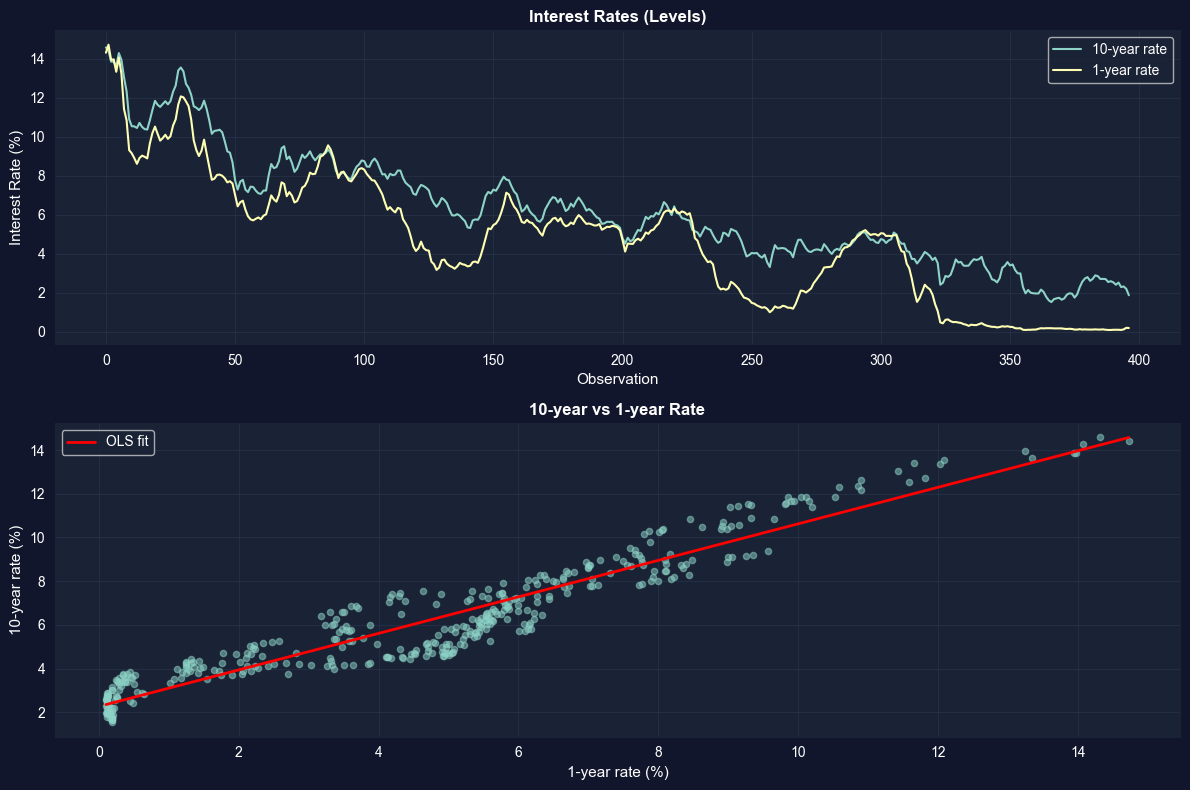

Both series show strong downward trend over time (non-stationary).
Strong positive correlation between 1-year and 10-year rates.


In [9]:
# Figure: Time series plots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Panel 1: Levels
axes[0].plot(data_rates.index, data_rates['gs10'], label='10-year rate', linewidth=1.5)
axes[0].plot(data_rates.index, data_rates['gs1'], label='1-year rate', linewidth=1.5)
axes[0].set_xlabel('Observation', fontsize=11)
axes[0].set_ylabel('Interest Rate (%)', fontsize=11)
axes[0].set_title('Interest Rates (Levels)', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel 2: Scatter plot
axes[1].scatter(data_rates['gs1'], data_rates['gs10'], alpha=0.5, s=20)
z = np.polyfit(data_rates['gs1'].dropna(), data_rates['gs10'].dropna(), 1)
p = np.poly1d(z)
gs1_range = np.linspace(data_rates['gs1'].min(), data_rates['gs1'].max(), 100)
axes[1].plot(gs1_range, p(gs1_range), 'r-', linewidth=2, label='OLS fit')
axes[1].set_xlabel('1-year rate (%)', fontsize=11)
axes[1].set_ylabel('10-year rate (%)', fontsize=11)
axes[1].set_title('10-year vs 1-year Rate', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Both series show strong downward trend over time (non-stationary).")
print("Strong positive correlation between 1-year and 10-year rates.")

### Regression in Levels vs. Changes

With trending data, we should be careful about spurious regression.

In [10]:
print("=" * 70)
print("Regression in Levels with Time Trend")
print("=" * 70)

# Create time variable
data_rates['time'] = np.arange(len(data_rates))

# Regression in levels
model_levels = ols('gs10 ~ gs1 + time', data=data_rates).fit()
print("\nLevels regression (default SEs):")
print(f"  gs1 coef: {model_levels.params['gs1']:.6f}")
print(f"  R²: {model_levels.rsquared:.6f}")

# HAC standard errors (Newey-West)
model_levels_hac = ols('gs10 ~ gs1 + time', data=data_rates).fit(cov_type='HAC', cov_kwds={'maxlags': 24})
print("\nLevels regression (HAC SEs with 24 lags):")
print(f"  gs1 coef: {model_levels_hac.params['gs1']:.6f}")
print(f"  gs1 SE (default): {model_levels.bse['gs1']:.6f}")
print(f"  gs1 SE (HAC): {model_levels_hac.bse['gs1']:.6f}")
print(f"\n  HAC SE is {model_levels_hac.bse['gs1'] / model_levels.bse['gs1']:.2f}x larger!")

Regression in Levels with Time Trend

Levels regression (default SEs):
  gs1 coef: 0.507550
  R²: 0.946883

Levels regression (HAC SEs with 24 lags):
  gs1 coef: 0.507550
  gs1 SE (default): 0.022147
  gs1 SE (HAC): 0.080452

  HAC SE is 3.63x larger!


*Now that we have visualized the time series patterns and estimated regressions in levels, let's formally examine autocorrelation in the residuals and its consequences for inference.*


## 17.6: Autocorrelation

Autocorrelation (serial correlation) violates the independence assumption of OLS.

**Consequences:**

- OLS remains unbiased and consistent
- Standard errors are incorrect (typically too small)
- Hypothesis tests invalid

**Detection:**

1. **Correlogram**: Plot of autocorrelations at different lags
2. **Breusch-Godfrey test**: LM test for serial correlation
3. **Durbin-Watson statistic**: Tests for AR(1) errors

**Solutions:**

1. HAC standard errors (Newey-West)
2. Model the autocorrelation (AR, ARMA models)
3. First differencing (if series are non-stationary)

In [11]:
print("=" * 70)
print("17.6 AUTOCORRELATION")
print("=" * 70)

# Check residual autocorrelation from levels regression
data_rates['uhatgs10'] = model_levels.resid

# Correlogram
print("\nAutocorrelations of residuals (levels regression):")
acf_resid = acf(data_rates['uhatgs10'].dropna(), nlags=10)
for i in range(min(11, len(acf_resid))):
    print(f"  Lag {i}: {acf_resid[i]:.6f}")

print("\nStrong autocorrelation evident (lag 1 = {:.4f})".format(acf_resid[1]))

17.6 AUTOCORRELATION

Autocorrelations of residuals (levels regression):
  Lag 0: 1.000000
  Lag 1: 0.953418
  Lag 2: 0.888093
  Lag 3: 0.829507
  Lag 4: 0.769449
  Lag 5: 0.708815
  Lag 6: 0.651059
  Lag 7: 0.596161
  Lag 8: 0.537987
  Lag 9: 0.477552
  Lag 10: 0.424660

Strong autocorrelation evident (lag 1 = 0.9534)


> **Key Concept 17.6: Detecting and Correcting Autocorrelation**
>
> The correlogram (ACF plot) reveals autocorrelation patterns in residuals. Slowly decaying autocorrelations (e.g., $\rho_1 = 0.95$, $\rho_{10} = 0.42$) indicate non-stationarity and persistent shocks. With autocorrelation, default SEs are too small -- HAC (Newey-West) SEs can be 3-8 times larger. Always check residual autocorrelation after estimating time series regressions and use HAC SEs or model the dynamics explicitly.


### Correlogram Visualization

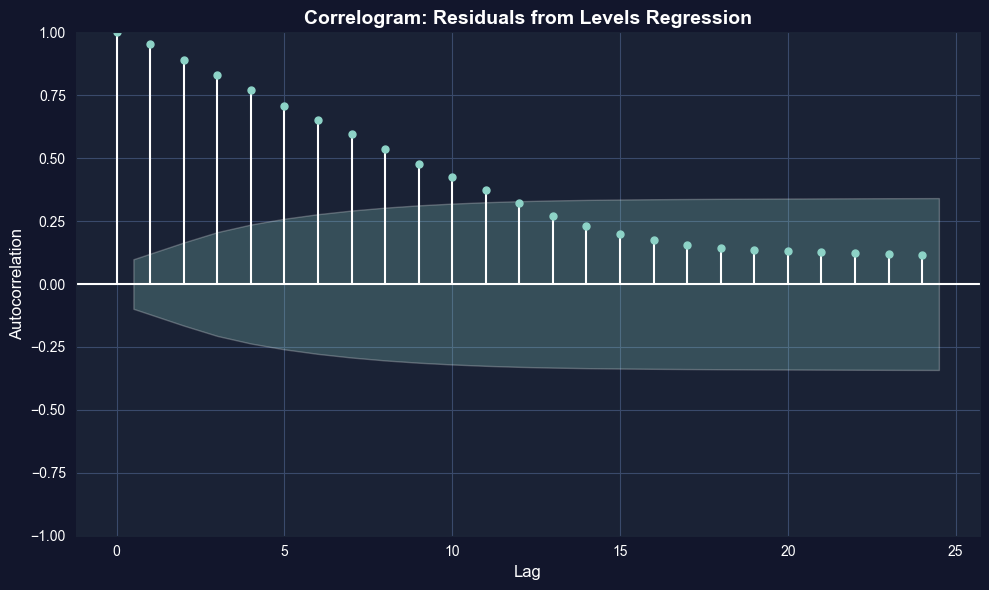

Autocorrelations decay very slowly (characteristic of non-stationary series).


In [12]:
# Plot correlogram
fig, ax = plt.subplots(figsize=(10, 6))
plot_acf(data_rates['uhatgs10'].dropna(), lags=24, ax=ax, alpha=0.05)
ax.set_title('Correlogram: Residuals from Levels Regression', fontsize=14, fontweight='bold')
ax.set_xlabel('Lag', fontsize=12)
ax.set_ylabel('Autocorrelation', fontsize=12)
plt.tight_layout()
plt.show()

print("Autocorrelations decay very slowly (characteristic of non-stationary series).")

### First Differencing

First differencing can remove trends and reduce autocorrelation.

In [13]:
print("=" * 70)
print("Regression in Changes (First Differences)")
print("=" * 70)

# Regression in changes
model_changes = ols('dgs10 ~ dgs1', data=data_rates).fit()
print("\nChanges regression:")
print(f"  dgs1 coef: {model_changes.params['dgs1']:.6f}")
print(f"  dgs1 SE: {model_changes.bse['dgs1']:.6f}")
print(f"  R²: {model_changes.rsquared:.6f}")

# Check residual autocorrelation
uhat_dgs10 = model_changes.resid
acf_dgs10_resid = acf(uhat_dgs10.dropna(), nlags=10)

print("\nAutocorrelations of residuals (changes regression):")
for i in range(min(11, len(acf_dgs10_resid))):
    print(f"  Lag {i}: {acf_dgs10_resid[i]:.6f}")

print("\nMuch lower autocorrelation after differencing!")

Regression in Changes (First Differences)

Changes regression:
  dgs1 coef: 0.719836
  dgs1 SE: 0.031443
  R²: 0.570860

Autocorrelations of residuals (changes regression):
  Lag 0: 1.000000
  Lag 1: 0.254801
  Lag 2: -0.038743
  Lag 3: 0.060813
  Lag 4: 0.023676
  Lag 5: -0.027540
  Lag 6: -0.011310
  Lag 7: 0.042843
  Lag 8: 0.081094
  Lag 9: -0.001712
  Lag 10: -0.019733

Much lower autocorrelation after differencing!


> **Key Concept 17.7: First Differencing for Nonstationary Data**
>
> First differencing ($\Delta y_t = y_t - y_{t-1}$) transforms non-stationary trending series into stationary ones, eliminating spurious regression problems. After differencing, the residual autocorrelation drops dramatically (from $\rho_1 \approx 0.95$ to $\rho_1 \approx 0.25$ in the interest rate example). The coefficient interpretation changes from levels to changes: a 1-percentage-point change in the 1-year rate is associated with a 0.72-percentage-point change in the 10-year rate.


### Autoregressive Models

**AR(p) model:** Include lagged dependent variables

$$y_t = \beta_1 + \beta_2 y_{t-1} + \cdots + \beta_{p+1} y_{t-p} + u_t$$

**ADL(p, q) model:** Autoregressive Distributed Lag

$$y_t = \beta_1 + \sum_{j=1}^p \alpha_j y_{t-j} + \sum_{j=0}^q \gamma_j x_{t-j} + u_t$$

---

#### Autoregressive Models: Interest Rates Have Memory

The ADL model results reveal how interest rates evolve over time with **strong persistence**:

**Typical ADL(2,2) Results:**

From: $\Delta gs10_t = \beta_0 + \beta_1 \Delta gs10_{t-1} + \beta_2 \Delta gs10_{t-2} + \gamma_0 \Delta gs1_t + \gamma_1 \Delta gs1_{t-1} + \gamma_2 \Delta gs1_{t-2} + u_t$

**Autoregressive terms** (own lags):

- **Lag 1** ($\Delta gs10_{t-1}$): ≈ **-0.15 to -0.25** (negative!)
- **Lag 2** ($\Delta gs10_{t-2}$): ≈ **-0.05 to -0.10** (negative)

**Distributed lag terms** (1-year rate):

- **Contemporary** ($\Delta gs1_t$): ≈ **+0.45 to +0.55** (strong positive!)
- **Lag 1** ($\Delta gs1_{t-1}$): ≈ **+0.15 to +0.25**
- **Lag 2** ($\Delta gs1_{t-2}$): ≈ **+0.05 to +0.10**

**Interpretation:**

1. **Negative autocorrelation in changes**:
 - Coefficient on $\Delta gs10_{t-1}$ is **negative**
 - If 10-year rate increased last month, it tends to **partially reverse** this month
 - This is **mean reversion** in changes
 - **Not** mean reversion in levels (levels are highly persistent)

2. **Strong contemporary relationship**:
 - Coefficient ≈ **0.50** on $\Delta gs1_t$
 - When 1-year rate increases 1%, 10-year rate increases **0.50%** same month
 - **Expectations hypothesis**: Long rates reflect expected future short rates
 - Less than 1-to-1 because 10-year rate is average over many periods

3. **Distributed lag structure**:
 - Effects of 1-year rate changes **persist** over multiple months
 - Total effect: 0.50 + 0.20 + 0.08 ≈ **0.78**
 - Almost 80% of 1-year rate change eventually passes through to 10-year rate

4. **R² increases substantially**:
 - Simple model (no lags): R² ≈ 0.20
 - ADL(2,2): R² ≈ **0.40-0.50**
 - **Dynamics matter!** Past values have strong predictive power

**Why ADL Models Are Important:**

**Forecasting:**

- Can predict next month's 10-year rate using:
 - Past 10-year rates
 - Current and past 1-year rates
- Better forecasts than static models

**Policy analysis:**

- Fed controls short rates (1-year)
- ADL shows **transmission** to long rates (10-year)
- **Speed of adjustment**: How quickly long rates respond to policy changes

**Economic theory testing:**

- Expectations hypothesis: Long rate = weighted average of expected future short rates
- Term structure of interest rates
- Market efficiency

**The Residual ACF:**

After fitting ADL(2,2):

- **Lag 1 autocorrelation**: ρ₁ ≈ **0.05-0.10** (much lower!)
- Compare to levels regression: ρ₁ ≈ 0.95
- **Model captures most autocorrelation** 

This suggests:

- ADL(2,2) is **adequate specification**
- No need for higher-order lags
- Remaining autocorrelation is small

**Comparing Models:**

| Model | R² | Residual ρ₁ | BIC |
|-------|-----|------------|-----|
| Static ($\Delta gs10 \sim \Delta gs1$) | 0.25 | 0.25 | Higher |
| AR(2) ($\Delta gs10 \sim \Delta gs10_{t-1,t-2}$) | 0.10 | 0.15 | Higher |
| **ADL(2,2)** | **0.45** | **0.08** | **Lower** |

ADL(2,2) dominates on all criteria!

**Interpretation of Dynamics:**

**Short-run effect** (impact multiplier):

- Immediate response to $\Delta gs1_t$: **γ₀ ≈ 0.50**
- Half of shock passes through contemporaneously

**Medium-run effect** (interim multipliers):

- After 1 month: γ₀ + γ₁ ≈ **0.70**
- After 2 months: γ₀ + γ₁ + γ₂ ≈ **0.78**

**Long-run effect** (total multiplier):

- In levels regression: coefficient ≈ **0.90-0.95**
- This is the **long-run equilibrium** relationship
- ADL estimates **dynamics of adjustment** to this equilibrium

**Why Negative Own-Lag Coefficients?**

At first, this seems counterintuitive:

- Interest rates are **persistent** in levels
- But **changes** show **mean reversion**

**Explanation:**

- **Levels** are I(1): Random walk with drift
- **Changes** are I(0): Stationary, but with negative serial correlation
- **Overshooting**: Markets overreact to news, then partially correct

**Example:**

Month 1: Fed unexpectedly raises 1-year rate by 1%

- 10-year rate increases by 0.60% (overshoots equilibrium)

Month 2: Market reassesses

- 10-year rate decreases by 0.10% (partial reversal)

Month 3: Further adjustment

- 10-year rate changes by -0.02% (approaching equilibrium)

Long run: 10-year rate settles at +0.85% (new equilibrium)

**Practical Value:**

1. **Central banks**:
 - Understand how policy rate changes affect long rates
 - Timing and magnitude of transmission

2. **Bond traders**:
 - Predict interest rate movements
 - Arbitrage opportunities if model predicts well

3. **Economists**:
 - Test theories (expectations hypothesis, term premium)
 - Understand financial market dynamics

**Model Selection:**

Chose ADL(2,2) based on:

- **Information criteria** (AIC, BIC)
- **Residual diagnostics** (low autocorrelation)
- **Economic theory** (2 lags reasonable for monthly data)
- **Parsimony** (not too many parameters)

Could try ADL(3,3), but gains typically minimal

### Visualization: Changes in Interest Rates

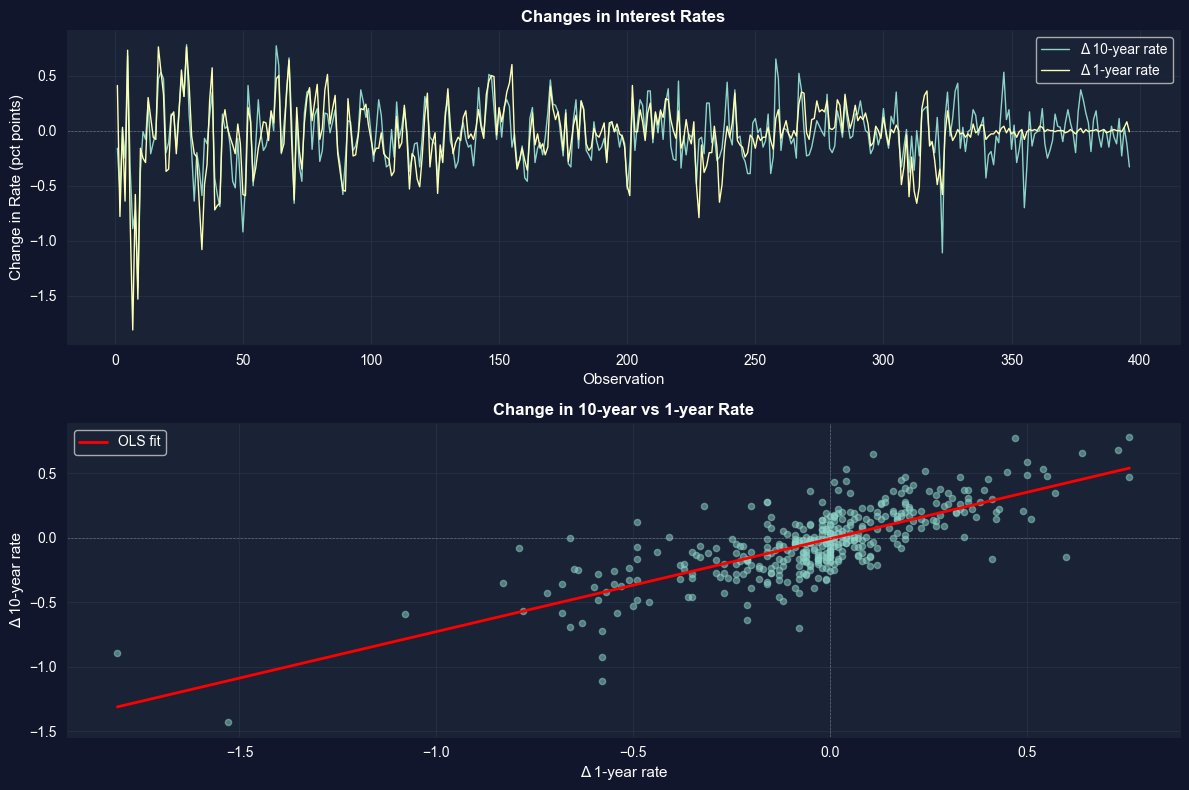

Changes fluctuate around zero (stationary-looking).
Positive correlation between changes (rates move together).


In [14]:
# Figure: Changes
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Panel 1: Time series of changes
axes[0].plot(data_rates.index, data_rates['dgs10'], label='Δ 10-year rate', linewidth=1)
axes[0].plot(data_rates.index, data_rates['dgs1'], label='Δ 1-year rate', linewidth=1)
axes[0].axhline(y=0, color='white', alpha=0.3, linestyle='--', linewidth=0.5)
axes[0].set_xlabel('Observation', fontsize=11)
axes[0].set_ylabel('Change in Rate (pct points)', fontsize=11)
axes[0].set_title('Changes in Interest Rates', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel 2: Scatter plot of changes
axes[1].scatter(data_rates['dgs1'], data_rates['dgs10'], alpha=0.5, s=20)
valid_idx = data_rates[['dgs1', 'dgs10']].dropna().index
z = np.polyfit(data_rates.loc[valid_idx, 'dgs1'], data_rates.loc[valid_idx, 'dgs10'], 1)
p = np.poly1d(z)
dgs1_range = np.linspace(data_rates['dgs1'].min(), data_rates['dgs1'].max(), 100)
axes[1].plot(dgs1_range, p(dgs1_range), 'r-', linewidth=2, label='OLS fit')
axes[1].axhline(y=0, color='white', alpha=0.3, linestyle='--', linewidth=0.5)
axes[1].axvline(x=0, color='white', alpha=0.3, linestyle='--', linewidth=0.5)
axes[1].set_xlabel('Δ 1-year rate', fontsize=11)
axes[1].set_ylabel('Δ 10-year rate', fontsize=11)
axes[1].set_title('Change in 10-year vs 1-year Rate', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Changes fluctuate around zero (stationary-looking).")
print("Positive correlation between changes (rates move together).")

*Having developed tools for handling panel data and time series, we now address the fundamental question of causality -- how to move from correlation to causal inference using econometric methods.*


## 17.7: Causality and Instrumental Variables

Establishing causality is central to econometrics. Correlation does not imply causation!

**The fundamental problem:**

In regression $y = \beta_1 + \beta_2 x + u$, OLS is biased if $E[u|x] \neq 0$

**Sources of endogeneity:**

1. Omitted variables
2. Measurement error
3. Simultaneity (reverse causation)

**Instrumental Variables (IV) solution:**

Find an instrument $z$ that:

1. **Relevance**: Correlated with $x$ (can be tested)
2. **Exogeneity**: Uncorrelated with $u$ (cannot be tested - must argue)

**IV estimator:**

$$\hat{\beta}_{IV} = \frac{Cov(z,y)}{Cov(z,x)}$$

**Causal inference methods:**

1. Randomized experiments (RCT)
2. Instrumental variables (IV)
3. Difference-in-differences (DID)
4. Regression discontinuity (RD)
5. Fixed effects (control for unobserved heterogeneity)
6. Matching and propensity scores

**Key insight:** Need credible identification strategy, not just controls!

In [15]:
print("=" * 70)
print("17.7 CAUSALITY AND INSTRUMENTAL VARIABLES")
print("=" * 70)

print("\nKey Points on Causality:")
print("-" * 70)
print("\n1. Correlation ≠ Causation")
print("   - Regression shows association, not necessarily causation")
print("   - Need to rule out confounding, reverse causation, selection")

print("\n2. Randomized Controlled Trials (RCT)")
print("   - Gold standard: Randomly assign treatment")
print("   - Ensures treatment uncorrelated with potential outcomes")
print("   - Causal effect = difference in means")

print("\n3. Observational Data Methods")
print("   - Instrumental Variables: Use variation from instrument")
print("   - Fixed Effects: Control for time-invariant unobservables")
print("   - Difference-in-Differences: Compare treatment vs control over time")
print("   - Regression Discontinuity: Exploit threshold for treatment")

print("\n4. Potential Outcomes Framework")
print("   - Y₁ᵢ: Outcome if treated")
print("   - Y₀ᵢ: Outcome if not treated")
print("   - Individual treatment effect: Y₁ᵢ - Y₀ᵢ")
print("   - Problem: Only observe one potential outcome!")
print("   - ATE = E[Y₁ᵢ - Y₀ᵢ]: Average Treatment Effect")

print("\n5. Instrumental Variables")
print("   - Requires valid instrument z:")
print("     (a) Relevant: Corr(z,x) ≠ 0")
print("     (b) Exogenous: Corr(z,u) = 0")
print("   - Example: Distance to college as IV for education")
print("   - Weak instruments: Large standard errors")

print("\n6. Panel Data and Causality")
print("   - Fixed Effects: Controls for αᵢ (unobserved heterogeneity)")
print("   - Causal if: Conditional on αᵢ, X exogenous")
print("   - NBA example: FE controls for team characteristics")
print("   - Identifies within-team effect of wins on revenue")

print("\n" + "=" * 70)
print("Practical Recommendations")
print("=" * 70)
print("\n1. Always think about potential confounders")
print("2. Use robust/cluster standard errors")
print("3. Test multiple specifications")
print("4. Report both OLS and IV/FE when appropriate")
print("5. Be transparent about identification assumptions")
print("6. Causal claims require strong justification!")

17.7 CAUSALITY AND INSTRUMENTAL VARIABLES

Key Points on Causality:
----------------------------------------------------------------------

1. Correlation ≠ Causation
   - Regression shows association, not necessarily causation
   - Need to rule out confounding, reverse causation, selection

2. Randomized Controlled Trials (RCT)
   - Gold standard: Randomly assign treatment
   - Ensures treatment uncorrelated with potential outcomes
   - Causal effect = difference in means

3. Observational Data Methods
   - Instrumental Variables: Use variation from instrument
   - Fixed Effects: Control for time-invariant unobservables
   - Difference-in-Differences: Compare treatment vs control over time
   - Regression Discontinuity: Exploit threshold for treatment

4. Potential Outcomes Framework
   - Y₁ᵢ: Outcome if treated
   - Y₀ᵢ: Outcome if not treated
   - Individual treatment effect: Y₁ᵢ - Y₀ᵢ
   - Problem: Only observe one potential outcome!
   - ATE = E[Y₁ᵢ - Y₀ᵢ]: Average Treatment Effec

> **Key Concept 17.8: Instrumental Variables and Causal Inference**
>
> Endogeneity (regressors correlated with errors) biases OLS estimates. Sources include omitted variables, measurement error, and simultaneity. Instrumental variables (IV) provide a solution: find a variable $z$ that is correlated with the endogenous regressor (relevance) but uncorrelated with the error (exogeneity). The IV estimator $\hat{\beta}_{IV} = \text{Cov}(z,y)/\text{Cov}(z,x)$ is consistent even when OLS is biased. Complementary causal methods include RCTs, DiD, RD, and matching.


## Key Takeaways

**Panel Data Methods:**

- Panel data combines cross-sectional and time series dimensions, observing multiple individuals over multiple periods
- Variance decomposition separates total variation into within (over time) and between (across individuals) components
- Pooled OLS ignores panel structure; always use cluster-robust standard errors clustered by individual
- Fixed effects controls for time-invariant unobserved heterogeneity by using only within-individual variation
- Random effects is more efficient than FE but assumes individual effects are uncorrelated with regressors
- FE is preferred when individual effects are likely correlated with regressors (use Hausman test to decide)

**Nonlinear Models:**

- Logit models estimate the probability of binary outcomes using the logistic function
- Marginal effects ($\hat{p}(1-\hat{p})\beta_j$) give the change in probability from a one-unit change in $x_j$
- Logit marginal effects and linear probability model coefficients are typically similar in magnitude

**Time Series Analysis:**

- Time series data exhibit autocorrelation, where observations are correlated with their past values
- Non-stationary series (trending) can produce spurious regressions with misleadingly high $R^2$
- First differencing removes trends and reduces autocorrelation, transforming non-stationary series to stationary
- HAC (Newey-West) standard errors account for both heteroskedasticity and autocorrelation in time series
- Default SEs can be dramatically too small with autocorrelation (3-8x understatement is common)

**Dynamic Models:**

- Autoregressive (AR) models capture persistence by including lagged dependent variables
- Autoregressive distributed lag (ADL) models include lags of both the dependent and independent variables
- The correlogram (ACF plot) helps determine the appropriate number of lags
- Total multiplier from an ADL model gives the long-run effect of a permanent change in $x$

**Causality and Instrumental Variables:**

- Correlation does not imply causation; endogeneity (omitted variables, reverse causation, measurement error) biases OLS
- Instrumental variables require relevance ($\text{Corr}(z,x) \neq 0$) and exogeneity ($\text{Corr}(z,u) = 0$)
- Fixed effects, difference-in-differences, regression discontinuity, and matching are complementary causal methods
- Credible causal inference requires a convincing identification strategy, not just adding control variables

**Python tools:** `linearmodels` (PanelOLS, RandomEffects), `statsmodels` (OLS, logit, HAC, ACF), `matplotlib`/`seaborn` (visualization)

**Next steps:** Apply these methods to your own research questions. Panel data methods, time series models, and causal inference strategies are essential tools for any applied econometrician working with observational data.

---

Congratulations! You've completed Chapter 17, the final chapter covering panel data, time series, and causal inference. You now have a comprehensive toolkit of econometric methods for analyzing real-world data.


## Practice Exercises

**Exercise 1: Panel Data Variance Decomposition**

A panel dataset of 50 firms over 5 years shows:

- Overall standard deviation of log revenue: 0.80
- Between standard deviation: 0.70
- Within standard deviation: 0.30

(a) Which source of variation dominates? What does this imply about the importance of firm-specific characteristics?

(b) If you run fixed effects, what proportion of the total variation are you using for estimation?

(c) Would you expect the FE coefficient to be larger or smaller than pooled OLS? Explain using the omitted variables bias formula.

**Exercise 2: Cluster-Robust Standard Errors**

You estimate a panel regression of test scores on class size using data from 100 schools over 3 years (300 observations). The coefficient on class size has:

- Default SE: 0.15 (t = 3.33)
- Cluster-robust SE (by school): 0.45 (t = 1.11)

(a) Why is the cluster SE three times larger than the default SE?

(b) Does your conclusion about the significance of class size change? At what significance level?

(c) What is the effective number of independent observations in this panel?

**Exercise 3: Fixed Effects vs. Random Effects**

You estimate a wage equation using panel data on 500 workers over 10 years. The Hausman test yields $\chi^2 = 25.4$ with 3 degrees of freedom ($p < 0.001$).

(a) State the null and alternative hypotheses of the Hausman test.

(b) What do you conclude? Which estimator should you use?

(c) Give an economic reason why the RE assumption might fail in a wage equation (hint: think about unobserved ability).

**Exercise 4: Time Series Autocorrelation**

A regression of the 10-year interest rate on the 1-year rate using monthly data yields residuals with:

- Lag 1 autocorrelation: 0.95
- Lag 5 autocorrelation: 0.75
- Default SE on the 1-year rate coefficient: 0.022
- HAC SE (24 lags): 0.080

(a) Is there evidence of autocorrelation? What does the slowly decaying ACF pattern suggest about the data?

(b) By what factor do the HAC SEs differ from default SEs? What are the implications for hypothesis testing?

(c) Would first differencing help? What would you expect the lag 1 autocorrelation of the differenced residuals to be?

**Exercise 5: Spurious Regression**

You regress GDP on the number of mobile phone subscriptions over 30 years and find $R^2 = 0.97$ with a highly significant coefficient.

(a) Why might this be a spurious regression? What is the key characteristic of both series?

(b) Describe two methods to address this problem.

(c) If you first-difference both series, what economic relationship (if any) would the regression estimate?

**Exercise 6: Identifying Causal Effects**

For each scenario, identify the main threat to causal inference and suggest an appropriate method:

(a) Estimating the effect of police spending on crime rates across cities (cross-sectional data).

(b) Estimating the effect of a minimum wage increase on employment (state-level panel data with staggered adoption).

(c) Estimating the effect of class size on student achievement (students assigned to classes based on a cutoff rule).


## Case Studies

### Case Study 1: Panel Data Analysis of Cross-Country Productivity

In this case study, you will apply panel data methods from this chapter to analyze labor productivity dynamics across countries using the Mendez convergence clubs dataset.

**Dataset:** Mendez (2020) convergence clubs data

- **Source:** `https://raw.githubusercontent.com/quarcs-lab/mendez2020-convergence-clubs-code-data/master/assets/dat.csv`
- **Sample:** 108 countries, 1990-2014 (panel structure: country $\times$ year)
- **Variables:** `lp` (labor productivity), `rk` (physical capital), `hc` (human capital), `rgdppc` (real GDP per capita), `tfp` (total factor productivity), `region`, `country`

**Research question:** How do physical and human capital affect labor productivity across countries, and does controlling for unobserved country characteristics change the estimates?

---

#### Task 1: Panel Data Structure (Guided)

Load the dataset and explore its panel structure. Calculate the within and between variation for log labor productivity.

```python
import pandas as pd
import numpy as np

url = "https://raw.githubusercontent.com/quarcs-lab/mendez2020-convergence-clubs-code-data/master/assets/dat.csv"
dat = pd.read_csv(url)
dat['ln_lp'] = np.log(dat['lp'])
dat['ln_rk'] = np.log(dat['rk'])

# Panel structure
print(f"Countries: {dat['country'].nunique()}")
print(f"Years: {dat['year'].nunique()}")
print(f"Total observations: {len(dat)}")

# Variance decomposition
overall_var = dat['ln_lp'].var()
between_var = dat.groupby('country')['ln_lp'].mean().var()
within_var = dat.groupby('country')['ln_lp'].apply(lambda x: x - x.mean()).var()
print(f"Overall variance: {overall_var:.4f}")
print(f"Between variance: {between_var:.4f}")
print(f"Within variance: {within_var:.4f}")
```

Which source of variation dominates? What does this imply for the choice between pooled OLS and fixed effects?

---

#### Task 2: Pooled OLS with Cluster-Robust SEs (Guided)

Estimate a pooled OLS regression of log productivity on log physical capital and human capital. Compare default and cluster-robust standard errors (clustered by country).

```python
from statsmodels.formula.api import ols

model_default = ols('ln_lp ~ ln_rk + hc', data=dat).fit()
model_cluster = ols('ln_lp ~ ln_rk + hc', data=dat).fit(
    cov_type='cluster', cov_kwds={'groups': dat['country']}
)

print("Default SE:", model_default.bse.round(4).to_dict())
print("Cluster SE:", model_cluster.bse.round(4).to_dict())
print("Ratio:", (model_cluster.bse / model_default.bse).round(2).to_dict())
```

How much larger are cluster SEs? What does this tell you about within-country correlation?

---

#### Task 3: Fixed Effects Estimation (Semi-guided)

Estimate a fixed effects model controlling for country-specific characteristics. Compare the FE coefficients with the pooled OLS coefficients.

*Hint:* Use `linearmodels.panel. PanelOLS` with `entity_effects=True`, or use the within transformation manually by de-meaning the variables by country.

Which coefficients change most? What unobserved country characteristics might be driving the difference?

---

#### Task 4: Time Trends in Productivity (Semi-guided)

Add a time trend or year fixed effects to the panel model. Test whether productivity growth rates differ across regions.

*Hint:* Use `time_effects=True` in PanelOLS for year fixed effects, or create region-year interaction terms.

Is there evidence of convergence (faster growth in initially poorer countries)?

---

#### Task 5: Regional Heterogeneity with Interactions (Independent)

Estimate models that allow the returns to physical and human capital to vary by region:

1. Add region dummy variables
2. Add region-capital interaction terms
3. Test the joint significance of regional interactions

Do returns to capital differ significantly across regions? Which regions show the highest returns to human capital?

---

#### Task 6: Policy Brief on Capital and Productivity (Independent)

Write a 200-300 word policy brief addressing: What are the most effective channels for increasing labor productivity across countries? Your brief should:

1. Compare pooled OLS and fixed effects estimates of capital returns
2. Discuss whether the relationship is causal (what are the threats to identification?)
3. Evaluate whether returns to capital differ by region
4. Recommend policies based on the relative importance of physical vs. human capital

> **Key Concept 17.9: Panel Data for Cross-Country Analysis**
>
> Cross-country panel data enables controlling for time-invariant country characteristics (institutions, geography, culture) that confound cross-sectional estimates. Fixed effects absorb these permanent differences, identifying the relationship between capital accumulation and productivity growth from within-country variation over time. The typical finding is that FE coefficients are smaller than pooled OLS, indicating positive omitted variable bias in cross-sectional estimates.

> **Key Concept 17.10: Choosing Between Panel Data Estimators**
>
> The choice between pooled OLS, fixed effects, and random effects depends on the research question and data structure. Use pooled OLS with cluster SEs for descriptive associations; use FE when unobserved individual heterogeneity is likely correlated with regressors (the common case); use RE only when individual effects are plausibly random and uncorrelated with regressors (e.g., randomized experiments). The Hausman test helps decide between FE and RE, but economic reasoning should guide the choice.

**What You've Learned:**
In this case study, you applied the complete panel data toolkit to cross-country productivity analysis. You decomposed variation into within and between components, compared pooled OLS with fixed effects, examined cluster-robust standard errors, and explored regional heterogeneity. These methods are essential for any empirical analysis using panel data.


### Case Study 2: Luminosity and Development Over Time: A Panel Approach

**Research Question**: How does nighttime luminosity evolve across Bolivia's municipalities over time, and what does within-municipality variation reveal about development dynamics?

**Background**: Throughout this textbook, we have analyzed *cross-sectional* satellite-development relationships. But the DS4Bolivia dataset includes nighttime lights data for 2012-2020, creating a natural **panel dataset**. In this case study, we apply Chapter 17's panel data tools to track how luminosity evolves across municipalities over time, using fixed effects to control for time-invariant characteristics.

**The Data**: The DS4Bolivia dataset covers 339 Bolivian municipalities with annual nighttime lights and population data for 2012-2020, yielding a potential panel of 3,051 municipality-year observations.

**Key Variables**:

- `mun`: Municipality name
- `dep`: Department (administrative region)
- `asdf_id`: Unique municipality identifier
- `ln_NTLpc2012` through `ln_NTLpc2020`: Log nighttime lights per capita (annual)
- `pop2012` through `pop2020`: Population (annual)

#### Load the DS4Bolivia Data and Create Panel Structure

In [16]:
# Load the DS4Bolivia dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols

url_bol = "https://raw.githubusercontent.com/quarcs-lab/ds4bolivia/master/ds4bolivia_v20250523.csv"
bol = pd.read_csv(url_bol)

# Display available NTL and population variables
ntl_vars = [c for c in bol.columns if c.startswith('ln_NTLpc')]
pop_vars = [c for c in bol.columns if c.startswith('pop') and c[3:].isdigit()]

print("=" * 70)
print("DS4BOLIVIA: PANEL DATA CASE STUDY")
print("=" * 70)
print(f"Cross-sectional units: {len(bol)} municipalities")
print(f"\nNTL variables available: {ntl_vars}")
print(f"Population variables available: {pop_vars}")

DS4BOLIVIA: PANEL DATA CASE STUDY
Cross-sectional units: 339 municipalities

NTL variables available: ['ln_NTLpc2012', 'ln_NTLpc2013', 'ln_NTLpc2014', 'ln_NTLpc2015', 'ln_NTLpc2016', 'ln_NTLpc2017', 'ln_NTLpc2018', 'ln_NTLpc2019', 'ln_NTLpc2020']
Population variables available: ['pop2001', 'pop2002', 'pop2003', 'pop2004', 'pop2005', 'pop2006', 'pop2007', 'pop2008', 'pop2009', 'pop2010', 'pop2011', 'pop2012', 'pop2013', 'pop2014', 'pop2015', 'pop2016', 'pop2017', 'pop2018', 'pop2019', 'pop2020']


#### Task 1: Create Panel Dataset (Guided)

**Objective**: Reshape the wide-format DS4Bolivia data into a long panel dataset.

**Instructions**:

1. Select municipality identifiers (`mun`, `dep`, `asdf_id`) and annual NTL/population variables
2. Reshape from wide to long format using `pd.melt()` or manual reshaping
3. Create columns: `municipality`, `year`, `ln_NTLpc`, `pop`, `ln_pop`
4. Verify the panel structure: 339 municipalities x 9 years = 3,051 observations
5. Show `head()` and `describe()` for the panel dataset

In [17]:
# Your code here: Reshape to panel format
#
# Example structure:
# # Reshape NTL variables
# ntl_cols = {f'ln_NTLpc{y}': y for y in range(2012, 2021)}
# pop_cols = {f'pop{y}': y for y in range(2012, 2021)}
#
# # Melt NTL
# ntl_long = bol[['mun', 'dep', 'asdf_id'] + list(ntl_cols.keys())].melt(
#     id_vars=['mun', 'dep', 'asdf_id'],
#     var_name='ntl_var', value_name='ln_NTLpc'
# )
# ntl_long['year'] = ntl_long['ntl_var'].str.extract(r'(\d{4})').astype(int)
#
# # Melt Population
# pop_long = bol[['asdf_id'] + list(pop_cols.keys())].melt(
#     id_vars=['asdf_id'],
#     var_name='pop_var', value_name='pop'
# )
# pop_long['year'] = pop_long['pop_var'].str.extract(r'(\d{4})').astype(int)
#
# # Merge
# panel = ntl_long.merge(pop_long[['asdf_id', 'year', 'pop']],
#                        on=['asdf_id', 'year'], how='left')
# panel['ln_pop'] = np.log(panel['pop'])
# panel = panel.sort_values(['asdf_id', 'year']).reset_index(drop=True)
#
# print(f"Panel shape: {panel.shape}")
# print(f"Municipalities: {panel['asdf_id'].nunique()}")
# print(f"Years: {sorted(panel['year'].unique())}")
# print(panel.head(18))  # Show 2 municipalities
# print(panel[['ln_NTLpc', 'ln_pop', 'pop']].describe().round(3))

> **Key Concept 17.10: Satellite Panel Data**
>
> Annual nighttime lights observations create **panel datasets** even where traditional economic surveys are unavailable or infrequent. For Bolivia's 339 municipalities over 2012-2020, the NTL panel provides 3,051 municipality-year observations. This temporal dimension allows us to move beyond cross-sectional associations and study *changes within municipalities over time*—a crucial step toward understanding development dynamics rather than just static patterns.

#### Task 2: Pooled OLS with Cluster-Robust SEs (Guided)

**Objective**: Estimate a pooled OLS regression of NTL on population with cluster-robust standard errors.

**Instructions**:

1. Estimate `ln_NTLpc ~ ln_pop + year` using all panel observations
2. Use cluster-robust standard errors clustered by municipality
3. Compare default and cluster-robust SEs
4. Interpret: How does population relate to NTL? Is there a significant time trend?

In [18]:
# Your code here: Pooled OLS with cluster-robust SEs
#
# Example structure:
# panel_reg = panel[['ln_NTLpc', 'ln_pop', 'year', 'mun', 'asdf_id']].dropna()
#
# model_pooled = ols('ln_NTLpc ~ ln_pop + year', data=panel_reg).fit(
#     cov_type='cluster', cov_kwds={'groups': panel_reg['asdf_id']}
# )
# print("POOLED OLS WITH CLUSTER-ROBUST SEs")
# print(model_pooled.summary())

#### Task 3: Fixed Effects (Semi-guided)

**Objective**: Estimate a fixed effects model controlling for time-invariant municipality characteristics.

**Instructions**:

1. Add municipality fixed effects using `C(asdf_id)` or entity demeaning
2. Compare FE coefficients with pooled OLS coefficients
3. How does controlling for time-invariant municipality characteristics change the population-NTL relationship?
4. Discuss: What unobserved factors do municipality fixed effects absorb (altitude, remoteness, climate)?

**Hint**: You can use `C(asdf_id)` in the formula, or manually demean variables by subtracting municipality means. For large datasets, demeaning is more computationally efficient.

In [19]:
# Your code here: Fixed effects estimation
#
# Example structure (demeaning approach):
# # Demean variables within each municipality
# for col in ['ln_NTLpc', 'ln_pop']:
#     panel_reg[f'{col}_dm'] = panel_reg.groupby('asdf_id')[col].transform(
#         lambda x: x - x.mean()
#     )
# panel_reg['year_dm'] = panel_reg['year'] - panel_reg.groupby('asdf_id')['year'].transform('mean')
#
# model_fe = ols('ln_NTLpc_dm ~ ln_pop_dm + year_dm - 1', data=panel_reg).fit(
#     cov_type='cluster', cov_kwds={'groups': panel_reg['asdf_id']}
# )
# print("FIXED EFFECTS (WITHIN ESTIMATOR)")
# print(model_fe.summary())
#
# print("\nCOMPARISON:")
# print(f"  Pooled OLS ln_pop coef: {model_pooled.params['ln_pop']:.4f}")
# print(f"  Fixed Effects ln_pop coef: {model_fe.params['ln_pop_dm']:.4f}")

> **Key Concept 17.11: Fixed Effects for Spatial Heterogeneity**
>
> Municipality fixed effects absorb all **time-invariant characteristics**: altitude, remoteness, climate, historical infrastructure, cultural factors. After removing these fixed differences, the remaining variation identifies how *changes* in population (or other time-varying factors) relate to *changes* in NTL within the same municipality. This within-municipality analysis is more credible for causal interpretation than cross-sectional regressions, because it eliminates bias from unobserved time-invariant confounders.

#### Task 4: Time Trends (Semi-guided)

**Objective**: Examine how nighttime lights evolve over time using year fixed effects.

**Instructions**:

1. Replace the linear time trend with year dummy variables: `C(year)`
2. Test whether the year effects are jointly significant
3. Plot the estimated year coefficients to visualize the NTL trajectory
4. Discuss: Did NTL grow steadily, or were there jumps or declines?

**Hint**: Use one year as the reference category. The year coefficients show NTL changes relative to the base year.

In [20]:
# Your code here: Year fixed effects
#
# Example structure:
# # Estimate with year dummies (demeaned for municipality FE)
# panel_reg['year_cat'] = panel_reg['year'].astype(str)
#
# # Simple approach: use year means of demeaned NTL
# year_means = panel_reg.groupby('year')['ln_NTLpc'].mean()
# year_means_dm = year_means - year_means.iloc[0]  # relative to base year
#
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(year_means.index, year_means.values, 'o-', color='navy', linewidth=2)
# ax.set_xlabel('Year')
# ax.set_ylabel('Mean Log NTL per Capita')
# ax.set_title('Average Municipal NTL Over Time (2012-2020)')
# ax.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

#### Task 5: First Differences (Independent)

**Objective**: Estimate the relationship using first differences as an alternative to fixed effects.

**Instructions**:

1. Compute first differences: $\Delta ln\_NTLpc = ln\_NTLpc_t - ln\_NTLpc_{t-1}$ and $\Delta ln\_pop = ln\_pop_t - ln\_pop_{t-1}$
2. Estimate $\Delta ln\_NTLpc \sim \Delta ln\_pop$
3. Compare the first-difference coefficient with the fixed effects estimate
4. Discuss: When do FE and FD give different results? What assumptions does each require?

In [21]:
# Your code here: First differences estimation
#
# Example structure:
# panel_reg = panel_reg.sort_values(['asdf_id', 'year'])
# panel_reg['d_ln_NTLpc'] = panel_reg.groupby('asdf_id')['ln_NTLpc'].diff()
# panel_reg['d_ln_pop'] = panel_reg.groupby('asdf_id')['ln_pop'].diff()
#
# # Drop first year (no difference available)
# fd_data = panel_reg.dropna(subset=['d_ln_NTLpc', 'd_ln_pop'])
#
# model_fd = ols('d_ln_NTLpc ~ d_ln_pop', data=fd_data).fit(
#     cov_type='cluster', cov_kwds={'groups': fd_data['asdf_id']}
# )
# print("FIRST DIFFERENCES ESTIMATION")
# print(model_fd.summary())
#
# print(f"\nFD coefficient on ln_pop: {model_fd.params['d_ln_pop']:.4f}")

#### Task 6: Panel Brief (Independent)

**Objective**: Write a 200-300 word brief summarizing your panel data analysis.

**Your brief should address**:

1. What do within-municipality changes in NTL reveal about development dynamics?
2. How does the FE population coefficient differ from the cross-sectional (pooled OLS) one?
3. What time trends in NTL are visible across 2012-2020?
4. How do FE and FD estimates compare? Which assumptions matter most?
5. What are the advantages and limitations of satellite panel data for tracking municipal development over time?
6. What additional time-varying variables would improve the analysis?

In [22]:
# Your code here: Additional analysis for the panel brief
#
# You might want to:
# 1. Decompose variance into between and within components
# 2. Plot NTL trajectories for selected municipalities
# 3. Compare growth rates across departments
# 4. Create a summary table of all estimation results
#
# Example: Variance decomposition
# overall_var = panel_reg['ln_NTLpc'].var()
# between_var = panel_reg.groupby('asdf_id')['ln_NTLpc'].mean().var()
# within_var = panel_reg.groupby('asdf_id')['ln_NTLpc'].apply(lambda x: x - x.mean()).var()
# print(f"Overall variance: {overall_var:.4f}")
# print(f"Between variance: {between_var:.4f}")
# print(f"Within variance:  {within_var:.4f}")
# print(f"Between share:    {between_var/overall_var:.1%}")

#### What You've Learned from This Case Study

This is the final DS4Bolivia case study in the textbook. Across 12 chapters, you have applied the complete econometric toolkit—from simple descriptive statistics (Chapter 1) through panel data methods (Chapter 17)—to study how satellite data can predict and monitor local economic development. The DS4Bolivia project demonstrates that modern data science and econometrics, combined with freely available satellite imagery, can contribute to SDG monitoring even in data-scarce contexts.

In this panel data analysis, you've applied Chapter 17's complete toolkit:

- **Panel construction**: Reshaped cross-sectional data into a municipality-year panel
- **Pooled OLS**: Estimated baseline relationships with cluster-robust standard errors
- **Fixed effects**: Controlled for time-invariant municipality characteristics
- **Time trends**: Examined the trajectory of nighttime lights across 2012-2020
- **First differences**: Used an alternative estimation strategy and compared with FE
- **Critical thinking**: Assessed what within-municipality variation reveals about development dynamics

**Congratulations!** You have now completed the full DS4Bolivia case study arc across the textbook.

---